# ****Capstone Project - The Battle of the Neighborhoods****

# **1. Introduction**

The Nuremberg Metropolitan Region comprises 3.5 million people on 21,800 square kilometres. It consists of the cities of Nuremberg, Fürth, Erlangen, Bayreuth and Bamberg and is one of Germany’s strongest economic areas. Due to a decline in historically prevalent industry, such as consumer electronics the area has lacked behind in economic development compared to other more famous German regions, such as Munich or Stuttgart. 

However, this is also means that real estate and wages are lower compared to its contemporaries. Thus, potential investors find a large pool of well-educated workers, consumers and relatively cheap real estate.

The optimal location for an investor would maximize population density, while minimizing real estate prices and competition. These values vary significantly from district to district and from city to city.
Therefore, we want to create a map, which charts all areas according to its real estate values, population and venue density.
Afterwards, each district is clustered according to the density of venues and business opportunities.


# 2. Data

**2.1 Data description**

The following data sources were identified to tackle the business problem:
•	The number of venues within the certain radius of each district (Foresquare API)

•	The net income per citizen per district. Source: 
http://www.boeckler.de/pdf/wsi_vm_verfuegbare_einkommen.xlsx

•	The population and the population density of the district. Source: 
http://www.daten.statistik.nuernberg.de/geoinf/ia_bezirksatlas/atlas.html

•	The housing prices per district. Source: 
https://www.wohnungsboerse.net/mietspiegel-Nuernberg/2176

•	The coordinates of each district. Source: Open Street Map 
https://nominatim.openstreetmap.org/ui/search.html?q=nuremberg


**2.2 Data Preparation**

In [17]:
#Importing and installing all necessary libaries

import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!pip -q install folium
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


**Load the district data from wikipedia**

In [18]:
df_pop_size = pd.read_excel('Districts.xlsx')
df_pop_size.rename(columns = {'Bezirk':'District','Name':'Borough', 'Fläche (ha)':'Size (ha)', 'Einwohner':'Population'}, inplace = True)
df_pop_size.head()

,District,Borough,Size (ha),Population
0,1,"Altstadt, St. Lorenz",86.7,5275
1,2,Marienvorstadt,60.0,1338
2,3,Tafelhof,64.7,1312
3,4,Gostenhof,51.8,9462
4,5,Himpfelshof,65.4,6193


**Load the location data that was scrapped from Open Street Map**

In [19]:
df_location = pd.read_excel('District_Coordinates.xlsx')
df_location.rename(columns = {'Bezirk':'District'}, inplace = True)
df_location = df_location.drop(columns=['Name'])
df_location.head()

,District,Latitude,Longitude
0,1,49.447654,11.081863
1,2,49.449398,11.090167
2,3,49.444268,11.070317
3,4,49.449685,11.059096
4,5,49.451141,11.063438


**Scrape the public information from a public record**

In [20]:
df_gov = pd.read_excel('District_Government.xlsx')
df_gov.rename(columns = {'Bezirk':'District','Bevölkerung Unter 18 in %':'Population below 18 in %','Haushalte insgesamt':'Number of Households', 'Arbeitlose':'Unemployed', 'Wohnung Fertigstellung':'Finished Houses', 'Bevölkerung mit Beschäftigung':'Population with Employment'}, inplace = True)
df_gov.head()

,District,Population below 18 in %,Number of Households,Population with Employment,Unemployed,Finished Houses
0,1,"7,5",3 605,2 334,227,14
1,2,"11,1",919,591,57,11
2,3,"17,8",676,557,72,-
3,4,"16,4",5 166,3 525,593,-
4,5,"13,6",3 616,2 614,196,-


**Scrape the cost of housing and real estate from a realtors report**

In [21]:
!pip install tabula-py
import tabula

#tabula.convert_into("Mietspiegel_Nuernberg_2020", "Mietspiegel_Nuernberg_2020.xlsx", output_format="xlsx")
df_housing = pd.read_excel("Mietspiegel_Nuernberg_2020.xlsx")
df_housing.rename(columns = {'Stadtteil':'Borough', '€ / m2':'Price per Sqm'}, inplace = True)
df_housing.head()

,Borough,Price per Sqm
0,Almoshof,12.11
1,Altenfurt Nord,9.97
2,"Altenfurt, Moorenbrunn",9.97
3,"Altstadt, St. Lorenz",12.58
4,"Altstadt, St. Sebald",12.74


**Merge it into a new dataframe and calculate population density**

In [22]:
Nürnberg = df_location.merge(df_pop_size, on='District', how='left')
Nürnberg = Nürnberg.merge(df_gov, on='District', how='left')
Nürnberg = Nürnberg.merge(df_housing, on='Borough', how='left')

In [23]:
Nürnberg.dtypes

District                       object
Latitude                      float64
Longitude                     float64
Borough                        object
Size (ha)                     float64
Population                      int64
Population below 18 in %       object
Number of Households           object
Population with Employment     object
Unemployed                     object
Finished Houses                object
Price per Sqm                 float64
dtype: object

In [24]:
Nürnberg['Population'] = Nürnberg['Population'].astype('float')
Nürnberg['Population Density'] = round(Nürnberg['Population']/Nürnberg['Size (ha)'])

In [25]:
Nürnberg.shape
Nürnberg.head()

,District,Latitude,Longitude,Borough,Size (ha),Population,Population below 18 in %,Number of Households,Population with Employment,Unemployed,Finished Houses,Price per Sqm,Population Density
0,1,49.447654,11.081863,"Altstadt, St. Lorenz",86.7,5275.0,"7,5",3 605,2 334,227,14,12.58,61.0
1,2,49.449398,11.090167,Marienvorstadt,60.0,1338.0,"11,1",919,591,57,11,NaN,22.0
2,3,49.444268,11.070317,Tafelhof,64.7,1312.0,"17,8",676,557,72,-,16.27,20.0
3,4,49.449685,11.059096,Gostenhof,51.8,9462.0,"16,4",5 166,3 525,593,-,12.50,183.0
4,5,49.451141,11.063438,Himpfelshof,65.4,6193.0,"13,6",3 616,2 614,196,-,12.45,95.0


**Retrieve the latitude and longitude for Nürnberg in order to use them in Foursquare**

In [26]:
address = 'Nürnberg'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Nürnberg are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Nürnberg are 49.453872, 11.077298.


**Define Foursquare Credentials and Version**

In [27]:
CLIENT_ID = 'GOINK1A2G20UREDNWAU1AKQ3B31SM31RIUWNZSAMPLD5L3MK' # your Foursquare ID
CLIENT_SECRET = '4YVQZPKHRFF12GXKMITYUWI5KJT5UZBOZYWQRIJMFSO1NCWR' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: GOINK1A2G20UREDNWAU1AKQ3B31SM31RIUWNZSAMPLD5L3MK
CLIENT_SECRET:4YVQZPKHRFF12GXKMITYUWI5KJT5UZBOZYWQRIJMFSO1NCWR


**Create a function to explore all venues for all neighborhoods in Nürnberg**

In [28]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

**Save the new venues in a dataframe**

In [29]:
LIMIT = 300
radius = 500
Nürnberg_venues = getNearbyVenues(names=Nürnberg['Borough'],
                                   latitudes=Nürnberg['Latitude'],
                                   longitudes=Nürnberg['Longitude'])

Altstadt, St. Lorenz
Marienvorstadt
Tafelhof
Gostenhof
Himpfelshof
Altstadt, St. Sebald
St. Johannis
Pirckheimerstraße
Wöhrd
Ludwigsfeld
Glockenhof
Guntherstraße
Galgenhof
Hummelstein
Gugelstraße
Steinbühl
Gibitzenhof
Sandreuth
Schweinau
St. Leonhard
Sündersbühl
Bärenschanze
Sandberg
Bielingplatz
Uhlandstraße
Maxfeld
Veilhof
Tullnau
Gleißhammer
Dutzendteich
Rangierbahnhof-Siedlung
Langwasser Nordwest
Langwasser Nordost
Beuthener Straße
Altenfurt Nord
Langwasser Südost
Langwasser Südwest
Altenfurt, Moorenbrunn
Gewerbepark Nürnberg-Feucht
Hasenbuck
Rangierbahnhof
Katzwanger Straße
Dianastraße
Trierer Straße
Gartenstadt
Werderau
Maiach
Katzwang, Reichelsdorf Ost, Reichelsdorfer Keller
Kornburg, Worzeldorf
Hohe Marter
Röthenbach West
Röthenbach Ost
Eibach
Reichelsdorf
Krottenbach, Mühlhof
Großreuth bei Schweinau
Gebersdorf
Gaismannshof
Höfen
Eberhardshof
Muggenhof
Westfriedhof
Schniegling
Wetzendorf
Buch
Thon
Almoshof
Kraftshof
Neunhof
Boxdorf
Großgründlach
Schleifweg
Schoppershof
Schafhof

In [30]:
Nürnberg_venues.shape
Nürnberg_venues.head(50)

,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Altstadt, St. Lorenz",49.447654,11.081863,Sangam,49.448187,11.081314,Indian Restaurant
1,"Altstadt, St. Lorenz",49.447654,11.081863,Kokoro,49.447690,11.080558,Sushi Restaurant
2,"Altstadt, St. Lorenz",49.447654,11.081863,Wurstdurst,49.447971,11.078928,Currywurst Joint
3,"Altstadt, St. Lorenz",49.447654,11.081863,Atelier-Bar,49.447632,11.082496,Hotel Bar
4,"Altstadt, St. Lorenz",49.447654,11.081863,Park Plaza,49.447502,11.083238,Hotel
5,"Altstadt, St. Lorenz",49.447654,11.081863,Drei Raben,49.448836,11.080116,Hotel
6,"Altstadt, St. Lorenz",49.447654,11.081863,Padelle d'Italia,49.449862,11.080408,Italian Restaurant
7,"Altstadt, St. Lorenz",49.447654,11.081863,Hotel Victoria,49.447668,11.080904,Hotel
8,"Altstadt, St. Lorenz",49.447654,11.081863,Hans im Glück - Burgergrill,49.448054,11.080534,Burger Joint
9,"Altstadt, St. Lorenz",49.447654,11.081863,Neues Museum,49.447691,11.080537,Art Museum


**Check the amount of venues returned for each district**

In [31]:
Nürnberg_venues.groupby('Borough').count()

,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Borough,,,,,,
Almoshof,3,3,3,3,3,3
Altenfurt Nord,6,6,6,6,6,6
"Altenfurt, Moorenbrunn",4,4,4,4,4,4
"Altstadt, St. Lorenz",60,60,60,60,60,60
"Altstadt, St. Sebald",100,100,100,100,100,100
Beuthener Straße,19,19,19,19,19,19
Bielingplatz,26,26,26,26,26,26
Boxdorf,4,4,4,4,4,4
Brunn,4,4,4,4,4,4


A map of Nürnberg is created with the coordinates of each Borough ("Bezirk") for later analysis.

In [32]:
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough in zip(Nürnberg['Latitude'], Nürnberg['Longitude'], Nürnberg['Borough']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

# **3. Methodology and Analysis**

The data is now downloaded, cleaned and merged into a single dataframe. The next step is to analysis the dataset to identify the optimal location.

The first step would be to perform a basic "exploratory data analysis (EDA). This means that the data is visually inspected to gather basic insights. Afterwards, additional data will be added if needed, or features will be dropped if they are deemed superflous. Finally, a cluster analysis will be performed, in order to identify the cluster with the best fitting features.

**3.1 Exploratory Analysis**

In [33]:
Nürnberg.describe()

,Latitude,Longitude,Size (ha),Population,Price per Sqm,Population Density
count,87.000000,87.000000,87.000000,87.000000,69.00000,87.000000
mean,49.444439,11.083357,214.419540,6085.137931,11.30058,54.298851
std,0.034312,0.045575,239.746302,4127.750869,1.62551,56.273649
min,49.350211,11.008870,42.700000,0.000000,8.76000,0.000000
25%,49.424535,11.051523,79.350000,2695.000000,10.18000,12.000000
50%,49.444268,11.079005,152.100000,5427.000000,10.93000,31.000000
75%,49.464734,11.106252,274.550000,8599.500000,12.11000,78.000000
max,49.530503,11.254852,1942.600000,19927.000000,16.82000,237.000000


Barcharts will be used to perform a first visualization.

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

D:\Programming\Anaconda\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Reduce the dataset to districts with a meaningfull population > 5000**

In [37]:
#Exclude districts without meaningfull population
Nürnberg_Largest = Nürnberg[Nürnberg.Population > 5000]
Nürnberg_Largest.head()
Nürnberg_Largest.describe()

,Latitude,Longitude,Size (ha),Population,Price per Sqm,Population Density
count,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000
mean,49.436837,11.083616,209.942857,8899.918367,11.096122,80.102041
std,0.030084,0.040072,290.673867,3183.247018,1.136196,60.698107
min,49.350211,11.019433,42.700000,5039.000000,8.760000,7.000000
25%,49.421028,11.059096,79.600000,6197.000000,10.370000,29.000000
50%,49.441333,11.077570,125.000000,8285.000000,10.920000,61.000000
75%,49.458691,11.105473,252.200000,10401.000000,11.750000,118.000000
max,49.487471,11.205308,1942.600000,19927.000000,14.250000,237.000000


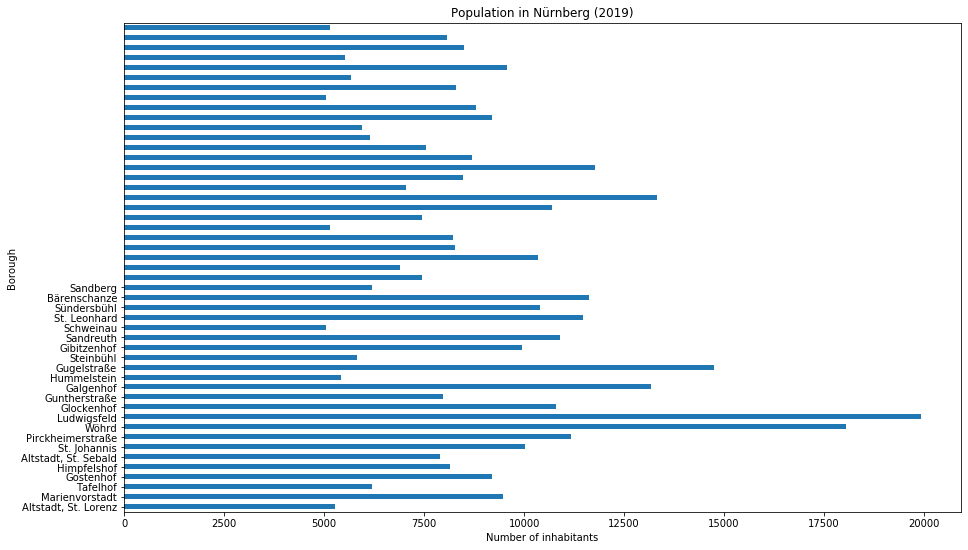

In [38]:
#Plot the population by district
Nürnberg_Largest[['Borough', 'Population']].plot(kind='barh', figsize=(15, 9), legend = None)
plt.xlabel('Number of inhabitants') # add to x-label to the plot
plt.ylabel('Borough') # add y-label to the plot
plt.title('Population in Nürnberg (2019)') # add title to the plot
plt.yticks (np.arange(23), Nürnberg['Borough'])
plt.show()

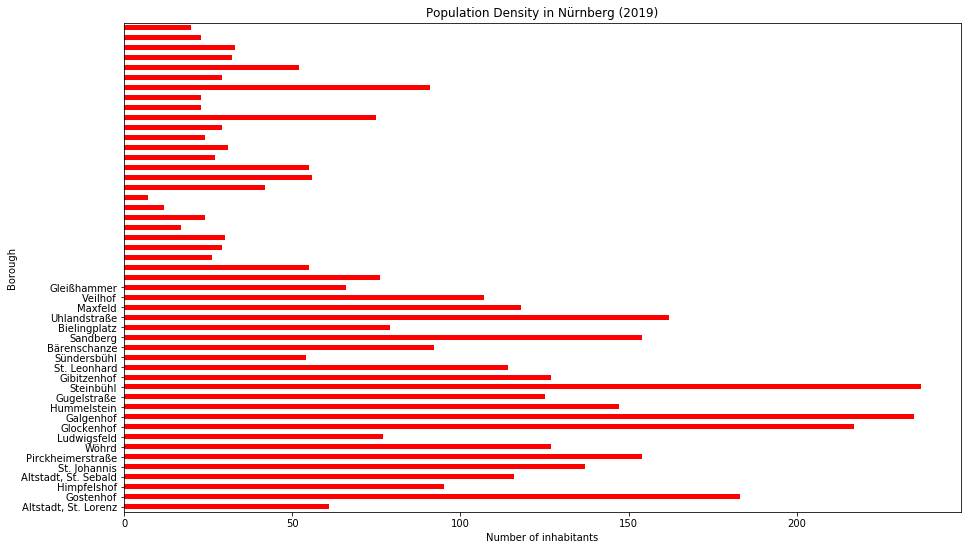

In [39]:
#Plot the population desnity by district
Nürnberg_Largest[['Borough', 'Population Density']].plot(kind='barh', figsize=(15, 9), legend = None, color="red")
plt.xlabel('Number of inhabitants') # add to x-label to the plot
plt.ylabel('Borough') # add y-label to the plot
plt.title('Population Density in Nürnberg (2019)') # add title to the plot
plt.yticks (np.arange(23), Nürnberg_Largest['Borough'])
plt.show()

**3.2 Cluster Analysis**

In order to identify groups (clusters) with similar characteristics, the unsupervised learning method "K-Means" will be applied to the data. In order to prepare the clustering, the following features will be removed.......


# 4. Results

abc

# 5. Conclusion

abc